In [8]:
# Importing necessary libraries and modules

# Standard library imports
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

# Third-party library imports
import cv2  # OpenCV library for image processing
import torch  # PyTorch library for tensor operations and deep learning
import requests  # Requests library for making HTTP requests
import numpy as np  # NumPy library for numerical operations
from PIL import Image  # Pillow library for image handling
import plotly.express as px  # Plotly Express for simple plotting
import matplotlib.pyplot as plt  # Matplotlib for plotting
import plotly.graph_objects as go  # Plotly for more complex plotting

# Importing classes and functions from the transformers library
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline

In [9]:
@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        """
        Converts the bounding box coordinates to a list format [xmin, ymin, xmax, ymax].
        :return: List of bounding box coordinates.
        """
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        """
        Creates a DetectionResult instance from a dictionary.
        :param detection_dict: Dictionary containing detection data with keys 'score', 'label', and 'box'.
        :return: DetectionResult instance.
        """
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                          


In [77]:
def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:
    """
    Annotate the image with bounding boxes and masks from detection results.
    
    :param image: Input image, either as a PIL Image or an OpenCV image (numpy array).
    :param detection_results: List of DetectionResult objects containing detection details.
    :return: Annotated image as a numpy array in RGB format.
    """
    # Convert PIL Image to OpenCV format if necessary
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    # Convert color from RGB to BGR for OpenCV compatibility
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # Iterate over detections and add bounding boxes and masks
    for detection in detection_results:
        label = detection.label  # Get the label of the detection
        score = detection.score  # Get the score of the detection
        box = detection.box  # Get the bounding box of the detection
        mask = detection.mask  # Get the mask of the detection, if available

        # Sample a random color for each detection
        color = np.random.randint(0, 256, size=3)

        # Draw bounding box on the image
        cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color.tolist(), 2)
        # Put label and score text above the bounding box
        cv2.putText(image_cv2, f'{label}: {score:.2f}', (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        # If mask is available, apply it
        if mask is not None:
            # Convert mask to uint8 format
            mask_uint8 = (mask * 255).astype(np.uint8)
            
            # Find contours of the mask
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Create a mask for filling the inside of the contours
            mask_filled = np.zeros_like(image_cv2)
            
            # Fill the inside of the contours with the specified color
            cv2.fillPoly(mask_filled, contours, color.tolist())
            
            # Apply the filled mask to the original image
            # Create a condition to replace the image's color only inside the contours
            mask_indices = mask_filled.astype(bool)
            image_cv2[mask_indices] = mask_filled[mask_indices]
                        
    # Convert the image back to RGB format
    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = None
) -> None:
    """
    Plot the detections on the image and display it. Optionally, save the annotated image.
    
    :param image: Input image, either as a PIL Image or an OpenCV image (numpy array).
    :param detections: List of DetectionResult objects containing detection details.
    :param save_name: Optional name for saving the annotated image.
    """
    # Annotate the image with detection results
    annotated_image = annotate(image, detections)
    
    # Display the annotated image using matplotlib
    plt.imshow(annotated_image)
    plt.axis('off')  # Hide the axis
    
    # Save the annotated image if a save name is provided
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
    
    # Show the plot
    plt.show()

In [78]:
def load_image(image_str: str) -> Image.Image:
    """
    Load an image from a URL or local file path.

    :param image_str: URL or local file path to the image.
    :return: Loaded image as a PIL Image object in RGB format.
    """
    if image_str.startswith("http"):
        # Load image from URL
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        # Load image from local file path
        image = Image.open(image_str).convert("RGB")

    return image

def get_boxes(results: List[DetectionResult]) -> List[List[List[float]]]:
    """
    Extract bounding box coordinates from detection results.

    :param results: List of DetectionResult objects.
    :return: List of bounding box coordinates in [xmin, ymin, xmax, ymax] format.
    """
    boxes = []
    for result in results:
        # Get bounding box coordinates as [xmin, ymin, xmax, ymax]
        xyxy = result.box.xyxy
        boxes.append(xyxy)

    return [boxes]

def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    """
    Refine and convert boolean masks to uint8 format.

    :param masks: Torch BoolTensor containing masks.
    :param polygon_refinement: Flag for polygon refinement (default is False).
    :return: List of refined masks as numpy arrays.
    """
    # Move masks to CPU and convert to float
    masks = masks.cpu().float()
    # Permute dimensions to match (batch_size, height, width, channels)
    masks = masks.permute(0, 2, 3, 1)
    # Average over the last dimension to combine channels
    masks = masks.mean(axis=-1)
    # Threshold masks to binary format
    masks = (masks > 0).int()
    # Convert masks to numpy arrays and change dtype to uint8
    masks = masks.numpy().astype(np.uint8)
    # Convert to list of numpy arrays
    masks = list(masks)

    return masks


In [79]:
def detect(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector: Optional[str] = None 
) -> List[Dict[str, Any]]:
    """
    Use Grounding DINO to detect a set of labels in an image in a zero-shot fashion.
    
    :param image: Input image as a PIL Image.
    :param labels: List of labels to detect in the image.
    :param threshold: Detection threshold.
    :param detector: Optional model identifier for the object detector.
    :return: List of detection results as dictionaries.
    """
    # Set default detector if none is provided
    detector = detector if detector is not None else "IDEA-Research/grounding-dino-tiny"
    
    # Initialize object detector pipeline
    object_detector = pipeline(model=detector,
                               task="zero-shot-object-detection", 
                               device='cuda')

    # Ensure labels end with a period
    labels = [label if label.endswith(".") else label + "." for label in labels]

    # Perform object detection
    results = object_detector(image, candidate_labels=labels, threshold=threshold)
    
    # Convert detection results to DetectionResult objects
    results = [DetectionResult.from_dict(result) for result in results]

    return results

def segment(
    image: Image.Image,
    detection_results: List[Dict[str, Any]],
    segmenter: Optional[str] = None
) -> List[DetectionResult]:
    """
    Use Segment Anything (SAM) to generate masks given an image and a set of bounding boxes.
    
    :param image: Input image as a PIL Image.
    :param detection_results: List of detection results as dictionaries.
    :param segmenter: Optional model identifier for the segmenter.
    :return: List of DetectionResult objects with masks.
    """
    # Set default segmenter if none is provided
    segmenter = segmenter if segmenter is not None else "facebook/sam-vit-base"

    # Initialize segmentator model and processor
    segmentator = AutoModelForMaskGeneration.from_pretrained('facebook/sam-vit-base').to('cuda')
    processor = AutoProcessor.from_pretrained('facebook/sam-vit-base')

    # Get bounding boxes from detection results
    boxes = get_boxes(detection_results)
    
    # Prepare inputs for the segmentator
    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to('cuda')

    # Generate masks using the segmentator
    outputs = segmentator(**inputs)
    
    # Post-process masks to match the original image size
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    # Refine masks
    masks = refine_masks(masks)

    # Assign masks to corresponding detection results
    for detection_result, mask in zip(detection_results, masks):
        detection_result.mask = mask

    return detection_results

def grounded_segmentation(
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.3,
    detector: Optional[str] = None,
    segmenter: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    """
    Perform grounded segmentation by detecting objects and generating masks in an image.
    
    :param image: Input image as a PIL Image or file path (str).
    :param labels: List of labels to detect in the image.
    :param threshold: Detection threshold.
    :param detector: Optional model identifier for the object detector.
    :param segmenter: Optional model identifier for the segmenter.
    :return: Tuple of annotated image as numpy array and list of DetectionResult objects.
    """
    # Load image if a file path is provided
    if isinstance(image, str):
        image = load_image(image)

    # Detect objects in the image
    detections = detect(image, labels, threshold, detector)
    
    # Generate masks for detected objects
    detections = segment(image, detections, segmenter)

    return np.array(image), detections


In [80]:
from datasets import load_dataset

dataset = load_dataset("goodfellowliu/City100")

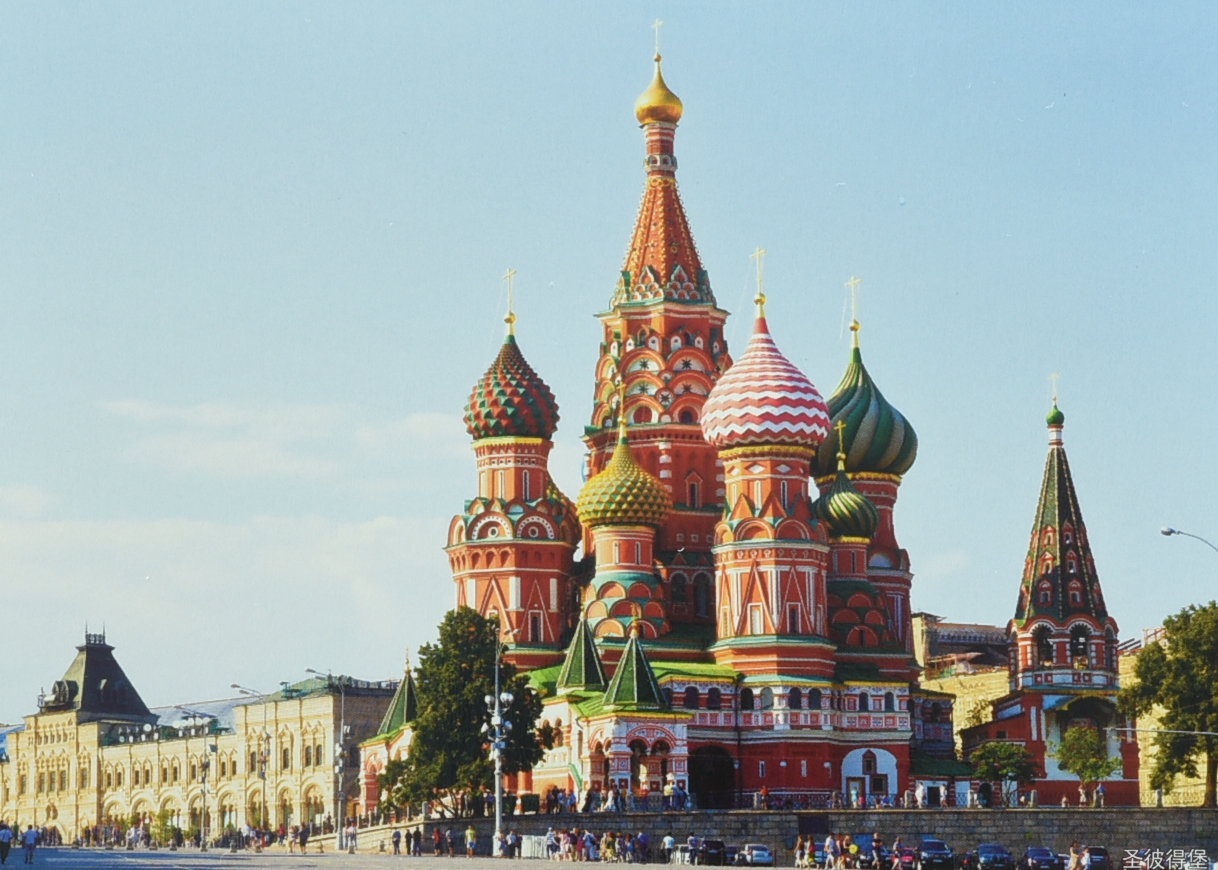

In [81]:
dataset['train'][0]['image']

In [82]:
num_samples = 5
seed = 221
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

In [83]:
labels = ["sky"]
threshold = 0.3

detector = "IDEA-Research/grounding-dino-tiny"
segmenter = "facebook/sam-vit-base"

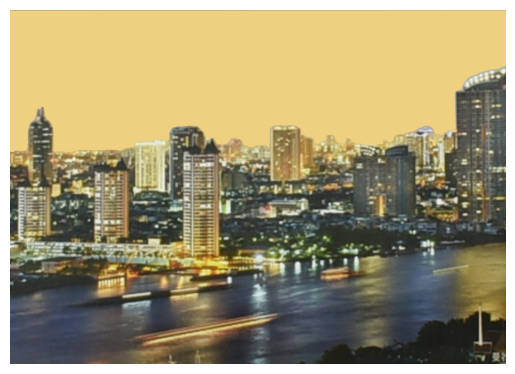

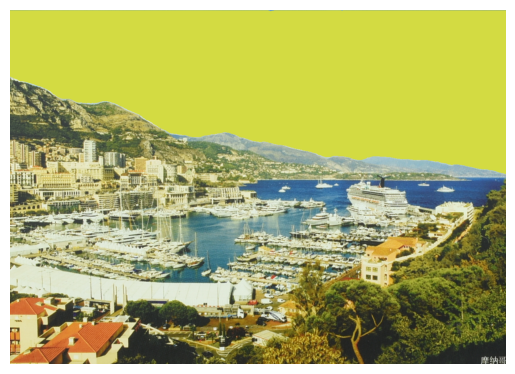

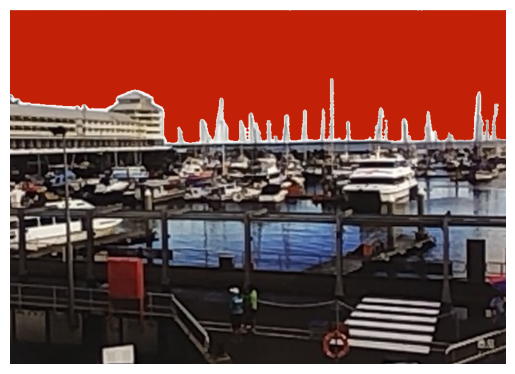

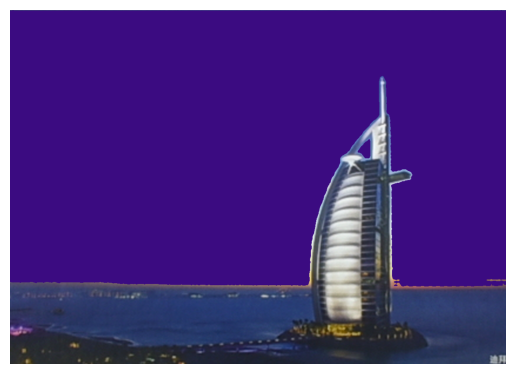

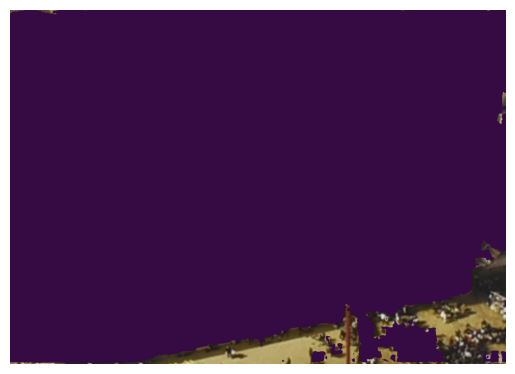

In [84]:
for i, example in enumerate(candidate_subset):
    image_array, detections = grounded_segmentation(
    image=example['image'],
    labels=labels,
    threshold=threshold,
    detector=detector,
    segmenter=segmenter)

    plot_detections(image_array, detections)